In [23]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

from collections import defaultdict
from itertools import izip

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
np.random.seed(42)

digits = load_digits()
data = scale(digits.data)
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
print "Loaded {} samples, {} features, {} digits. Labels: {} of shape {}".format(n_samples, n_features, n_digits, labels, labels.shape)

Loaded 1797 samples, 64 features, 10 digits. Labels: [0 1 2 ..., 8 9 8] of shape (1797,)


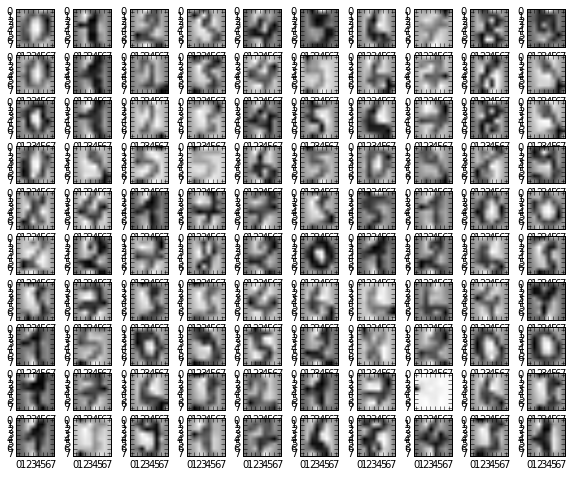

In [3]:
fig = plt.figure()
dim = 10

for i in xrange(dim * dim):
    a = fig.add_subplot(dim, dim, i + 1)
    imgplot = plt.imshow(np.reshape(data[i], (-1, 8)), cmap=plt.cm.binary)

    k-means++   0.48s   0.612   0.659   0.634   0.481   0.608    0.140
       random   0.62s   0.605   0.653   0.628   0.468   0.601    0.144
agglomerative   3.38s   0.017   0.249   0.032   0.000   0.009    0.475
    minibatch   0.06s   0.613   0.660   0.636   0.504   0.609    0.129
    PCA-based   0.04s   0.673   0.715   0.693   0.567   0.670    0.139
_______________________________________________________________________________


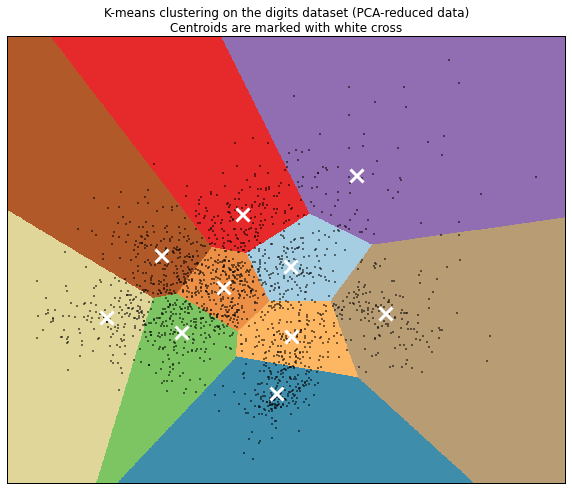

In [24]:

reduced_data = PCA(n_components=2).fit_transform(data)

save_files = False

sample_size = 300
def bench_estimator(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 13s   %.2fs   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0),
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
    
    if save_files:
        
        clusters = defaultdict(list)
        for l, img in izip(estimator.labels_, data):
            clusters[l].append(img)

        for l in sorted(clusters.iterkeys()):
            dir_name = os.path.join('clusters', name)
            if not os.path.exists(dir_name):
                os.makedirs(dir_name)
            
            fig = plt.figure()
            dim = 2
            for idx, im in enumerate(clusters[l]):
                if idx > 15:
                    break
                path = os.path.join(dir_name, str(l) + '_' + str(idx) + '.png')
                imgplot = plt.imshow(np.reshape(im, (-1, 8)), cmap=plt.cm.binary)
                fig.savefig(path)
                

bench_estimator(KMeans(init='k-means++', n_clusters=n_digits, n_init=10), name="k-means++", data=data)
bench_estimator(KMeans(init='random', n_clusters=n_digits, n_init=10), name="random", data=data)
bench_estimator(AgglomerativeClustering(linkage='complete', n_clusters=n_digits), name="agglomerative", data=data)
bench_estimator(MiniBatchKMeans(n_clusters=n_digits, n_init=10), name="minibatch", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_estimator(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

###############################################################################
# Visualize the results on PCA-reduced data

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [21]:
def plot_dataset(data, x, y, margin=50, frame=1000., imsize=8):
    x1 = (x - x.min()) * (frame / (x.max() - x.min())) + margin
    y1 = (y - y.min()) * (frame / (y.max() - y.min())) + margin
    image = np.zeros((x1.max() + margin + imsize, y1.max() + margin + imsize)) + 255
    print "Image size is %dx%d" % image.shape
    for k in xrange(data.shape[0]):
        image[x1[k]:x1[k]+8, y1[k]:y1[k]+8] = np.reshape(data[k], (-1, 8)) * 255
    plt.figure(figsize=(20, 20))
    plt.imshow(image, interpolation='none')
    plt.axis("off")
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Image size is 1108x1108


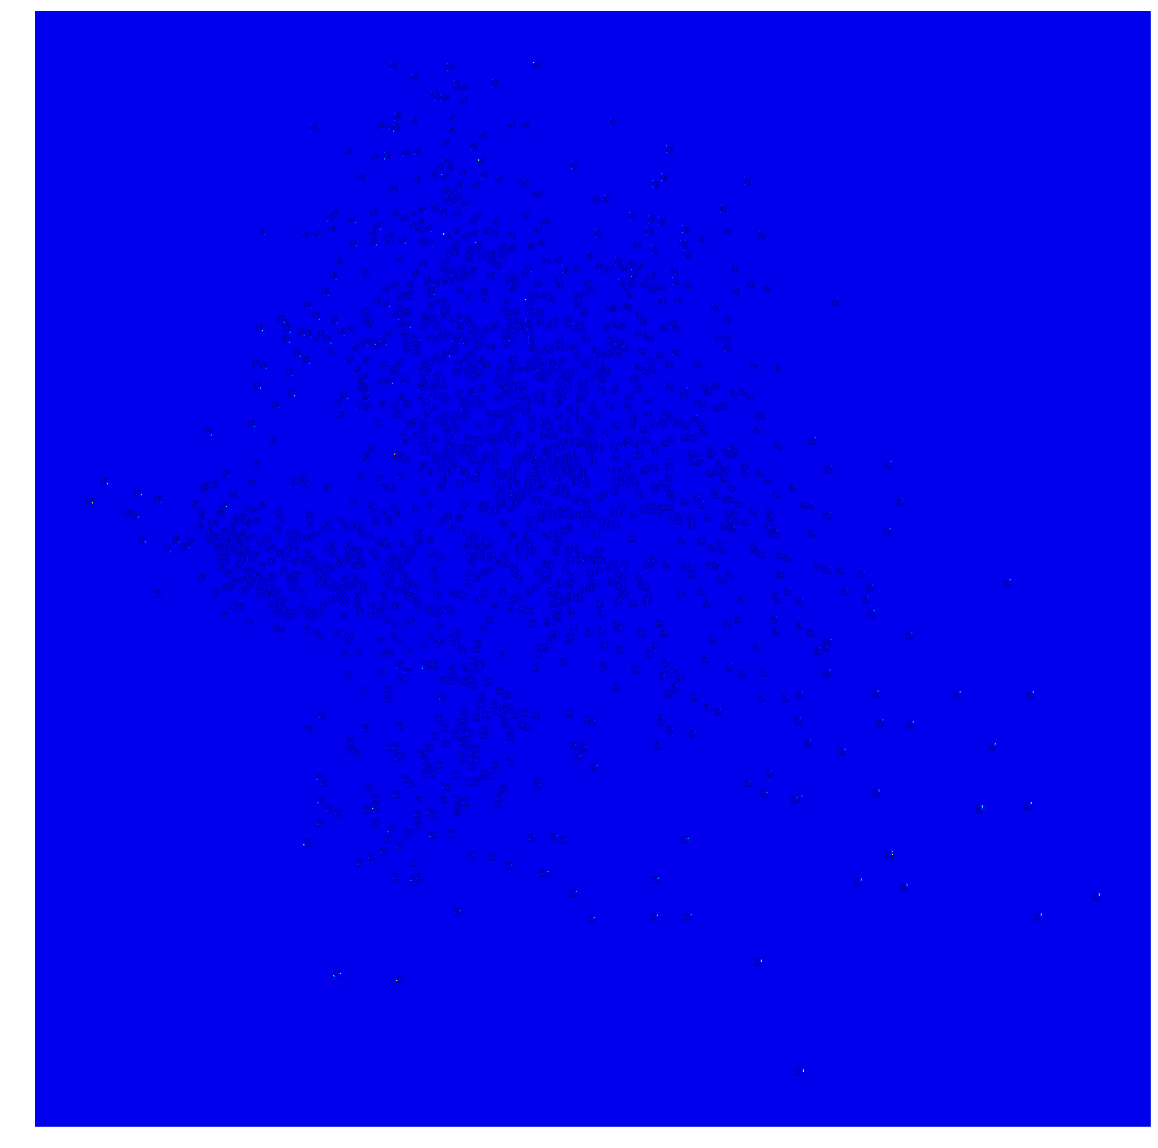

In [26]:
plot_dataset(data, reduced_data[:, 0], reduced_data[:, 1])